In [7]:
import pandas as pd

# Path to your downloaded CSV file
csv_path = "enterprise_t1059_logs_1000.csv"

# Load the dataset (low_memory=False prevents dtype guessing warnings)
print("Loading the dataset... this may take a minute.")
df = pd.read_csv(csv_path, low_memory=False)

print(f"Dataset loaded successfully! Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Display the first 20 rows to inspect the structure
df.head(20)

Loading the dataset... this may take a minute.
Dataset loaded successfully! Shape: 1,000 rows × 8 columns


,timestamp,user_name,parent_process,process,command,command_length,num_args,is_anomaly
0,02-11-25 06:13:08,svc_unknown,winword.exe,msiexec.exe,"powershell -Command ""$wc = New-Object System.N...",129,7,1
1,02-11-25 09:50:21,oleg.kov,winword.exe,msiexec.exe,cmd.exe /c echo hello,21,4,0
2,02-11-25 10:18:14,svc_sql,searchui.exe,schtasks.exe,msiexec /i C:\installers\app.msi /qn,36,4,0
3,02-11-25 11:16:03,li.chen,onedrive.exe,net.exe,whoami,6,1,0
4,02-11-25 11:31:33,svc_sql,msedge.exe,msiexec.exe,Get-Service,11,1,0
5,02-11-25 11:40:03,amir.cohen,explorer.exe,python.exe,Get-ChildItem C:\Users\Public,29,2,0
6,02-11-25 13:28:23,natalie.clark,excel.exe,schtasks.exe,whoami,6,1,0
7,02-11-25 13:46:19,qa.lisa,msedge.exe,net.exe,wscript C:\scripts\cleanup.vbs,30,2,0
8,02-11-25 13:54:09,li.chen,msedge.exe,net.exe,powershell -NoLogo -Command Get-EventLog -LogN...,72,8,0
9,02-11-25 14:15:50,oleg.kov,onedrive.exe,cscript.exe,Get-ChildItem C:\Users\Public,29,2,0


In [8]:
# Let's see which columns are available and what their data types are.

print("Dataset structure overview:\n")
df.info()

print("\nList of columns:")
print(", ".join(df.columns))

Dataset structure overview:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       1000 non-null   object
 1   user_name       1000 non-null   object
 2   parent_process  1000 non-null   object
 3   process         1000 non-null   object
 4   command         1000 non-null   object
 5   command_length  1000 non-null   int64 
 6   num_args        1000 non-null   int64 
 7   is_anomaly      1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB

List of columns:
timestamp, user_name, parent_process, process, command, command_length, num_args, is_anomaly


## Data Exploration

### Numeric features exploration

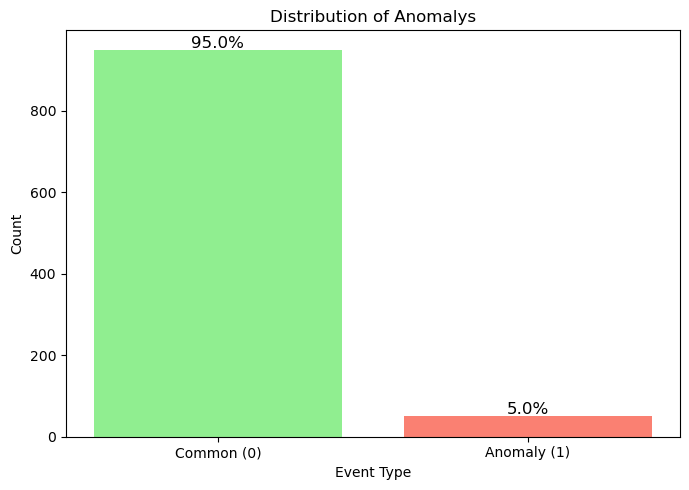

In [9]:
# === Distribution of attack classes and labels ===
import matplotlib.pyplot as plt

counts = df["is_anomaly"].value_counts().sort_index()

# Custom bar names
bar_labels = ["Common (0)", "Anomaly (1)"]
# Custom colors for each bar
colors = ["lightgreen", "salmon"]

plt.figure(figsize=(7, 5))

# Create the bar plot
plt.bar(bar_labels, counts.values, color=colors)

# Add numeric labels above bars
for i, value in enumerate(counts.values):
    plt.text(i, value + 5, str(value/10)+"%", ha='center', fontsize=12)

plt.xlabel("Event Type")
plt.ylabel("Count")
plt.title("Distribution of Anomalys")

plt.tight_layout()
plt.show()

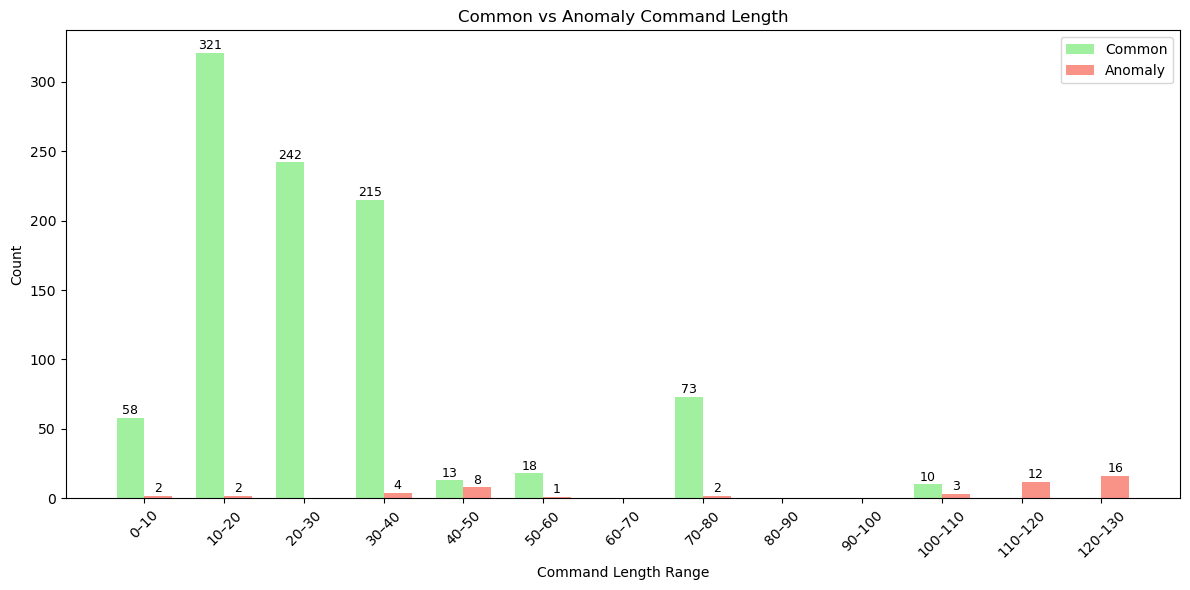

In [10]:
import numpy as np

# Define bins
max_len = df["command_length"].max()
bins = np.arange(0, max_len + 10, 10)

# Create bin labels
bin_labels = [f"{bins[i]}–{bins[i+1]}" for i in range(len(bins)-1)]

# Assign every row to a bin
df["length_bin"] = pd.cut(
    df["command_length"],
    bins=bins,
    labels=bin_labels,
    include_lowest=True
)

# Split normal + anomaly
anomalies = df[df["is_anomaly"] == 1]
normals   = df[df["is_anomaly"] == 0]

# Count per bin
anomaly_counts = anomalies["length_bin"].value_counts().reindex(bin_labels, fill_value=0)
normal_counts  = normals["length_bin"].value_counts().reindex(bin_labels, fill_value=0)

# Bar positions
x = np.arange(len(bin_labels))
width = 0.35

# Plot
plt.figure(figsize=(12, 6))
bars_normal = plt.bar(x - width/2, normal_counts.values, width, 
                      label="Common", color="lightgreen", alpha=0.85)
bars_anomaly = plt.bar(x + width/2, anomaly_counts.values, width, 
                       label="Anomaly", color="salmon", alpha=0.85)

# Add counts above bars
for bar in bars_normal:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), 
                 ha='center', va='bottom', fontsize=9)

for bar in bars_anomaly:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), 
                 ha='center', va='bottom', fontsize=9)

plt.xlabel("Command Length Range")
plt.ylabel("Count")
plt.title("Common vs Anomaly Command Length")
plt.xticks(x, bin_labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


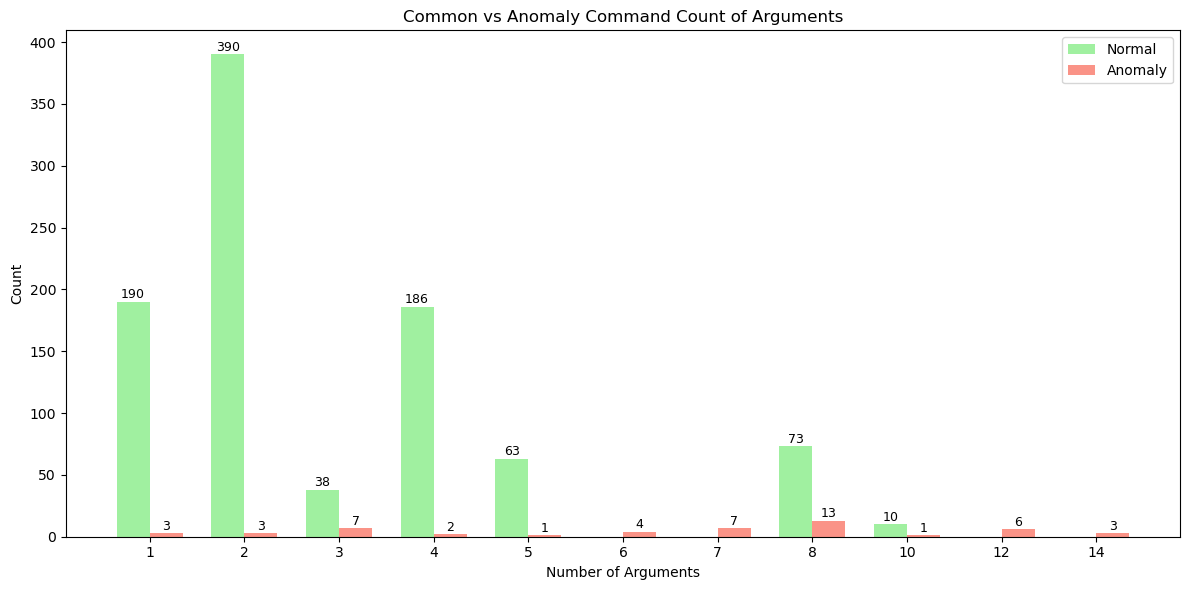

In [11]:

# Split normal + anomaly
anomalies = df[df["is_anomaly"] == 1]
normals   = df[df["is_anomaly"] == 0]

# Count occurrences of each num_args value
anomaly_counts = anomalies["num_args"].value_counts().sort_index()
normal_counts  = normals["num_args"].value_counts().sort_index()

# Combine all possible num_args values to make sure both have same x-axis
all_values = sorted(set(normal_counts.index) | set(anomaly_counts.index))
anomaly_counts = anomaly_counts.reindex(all_values, fill_value=0)
normal_counts  = normal_counts.reindex(all_values, fill_value=0)

# Bar positions
x = np.arange(len(all_values))
width = 0.35

# Plot
plt.figure(figsize=(12, 6))
bars_normal = plt.bar(x - width/2, normal_counts.values, width, 
                      label="Normal", color="lightgreen", alpha=0.85)
bars_anomaly = plt.bar(x + width/2, anomaly_counts.values, width, 
                       label="Anomaly", color="salmon", alpha=0.85)

# Add counts above bars, skip zeros
for bar in bars_normal:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, str(int(height)), 
                 ha='center', va='bottom', fontsize=9)

for bar in bars_anomaly:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, str(int(height)), 
                 ha='center', va='bottom', fontsize=9)

plt.xlabel("Number of Arguments")
plt.ylabel("Count")
plt.title("Common vs Anomaly Command Count of Arguments")
plt.xticks(x, all_values)
plt.legend()
plt.tight_layout()
plt.show()


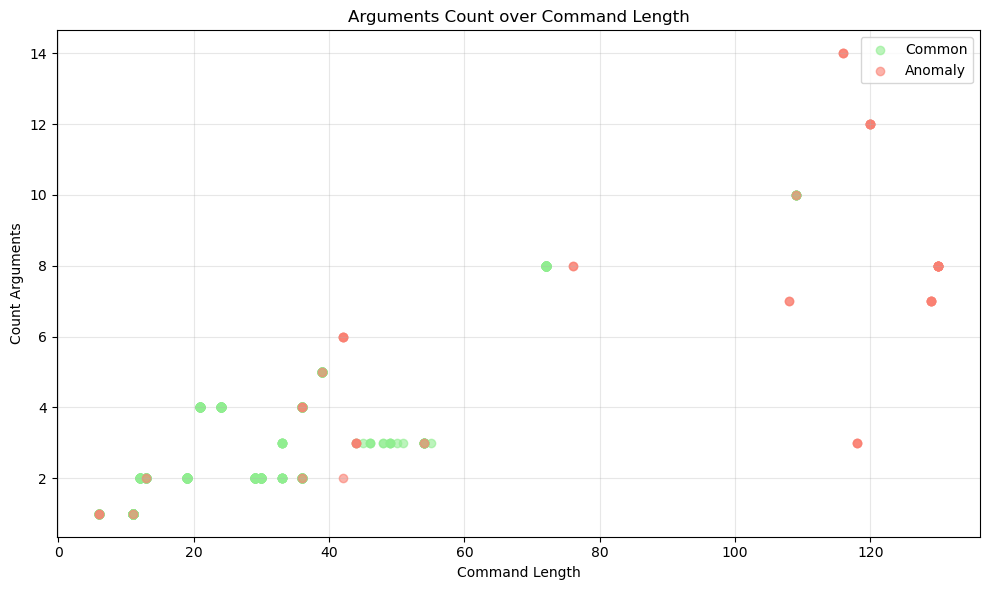

In [12]:
# Scatter plot
plt.figure(figsize=(10, 6))

# Plot normal commands
plt.scatter(
    df[df["is_anomaly"] == 0]["command_length"],
    df[df["is_anomaly"] == 0]["num_args"],
    color="lightgreen",
    alpha=0.6,
    label="Common"
)

# Plot anomalous commands
plt.scatter(
    df[df["is_anomaly"] == 1]["command_length"],
    df[df["is_anomaly"] == 1]["num_args"],
    color="salmon",
    alpha=0.6,
    label="Anomaly"
)

plt.xlabel("Command Length")
plt.ylabel("Count Arguments")
plt.title("Arguments Count over Command Length")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Feature Engineering

In [13]:

# Create mapping
parent_process_mapping = {name: idx for idx, name in enumerate(df["parent_process"].unique())}
process_mapping = {name: idx for idx, name in enumerate(df["process"].unique())}

# add process_id column with numeric process IDs
df["parent_process_id"] = df["parent_process"].map(parent_process_mapping)
df["process_id"] = df["process"].map(process_mapping)

df.head()

,timestamp,user_name,parent_process,process,command,command_length,num_args,is_anomaly,length_bin,parent_process_id,process_id
0,02-11-25 06:13:08,svc_unknown,winword.exe,msiexec.exe,"powershell -Command ""$wc = New-Object System.N...",129,7,1,120–130,0,0
1,02-11-25 09:50:21,oleg.kov,winword.exe,msiexec.exe,cmd.exe /c echo hello,21,4,0,20–30,0,0
2,02-11-25 10:18:14,svc_sql,searchui.exe,schtasks.exe,msiexec /i C:\installers\app.msi /qn,36,4,0,30–40,1,1
3,02-11-25 11:16:03,li.chen,onedrive.exe,net.exe,whoami,6,1,0,0–10,2,2
4,02-11-25 11:31:33,svc_sql,msedge.exe,msiexec.exe,Get-Service,11,1,0,10–20,3,0


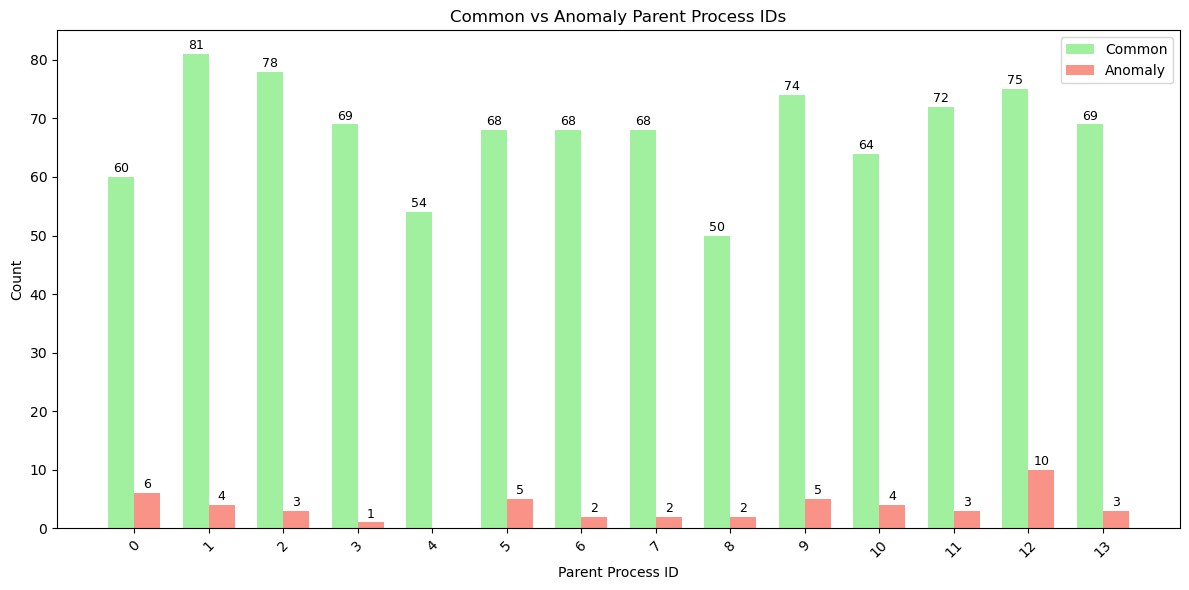

In [19]:
# Split normal and anomalous
anomalies = df[df["is_anomaly"] == 1]
normals   = df[df["is_anomaly"] == 0]

# Count occurrences of each process_id
anomaly_counts = anomalies["parent_process_id"].value_counts().sort_index()
normal_counts  = normals["parent_process_id"].value_counts().sort_index()

# Make sure both have same x-axis
all_ids = sorted(set(normal_counts.index) | set(anomaly_counts.index))
anomaly_counts = anomaly_counts.reindex(all_ids, fill_value=0)
normal_counts  = normal_counts.reindex(all_ids, fill_value=0)

# Bar positions
x = np.arange(len(all_ids))
width = 0.35

# Plot
plt.figure(figsize=(12, 6))
bars_normal = plt.bar(x - width/2, normal_counts.values, width, 
                      label="Common", color="lightgreen", alpha=0.85)
bars_anomaly = plt.bar(x + width/2, anomaly_counts.values, width, 
                       label="Anomaly", color="salmon", alpha=0.85)

# Add counts above bars, skip zeros
for bar in bars_normal:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, str(int(height)), 
                 ha='center', va='bottom', fontsize=9)

for bar in bars_anomaly:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, str(int(height)), 
                 ha='center', va='bottom', fontsize=9)

plt.xlabel("Parent Process ID")
plt.ylabel("Count")
plt.title("Common vs Anomaly Parent Process IDs")
plt.xticks(x, all_ids, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

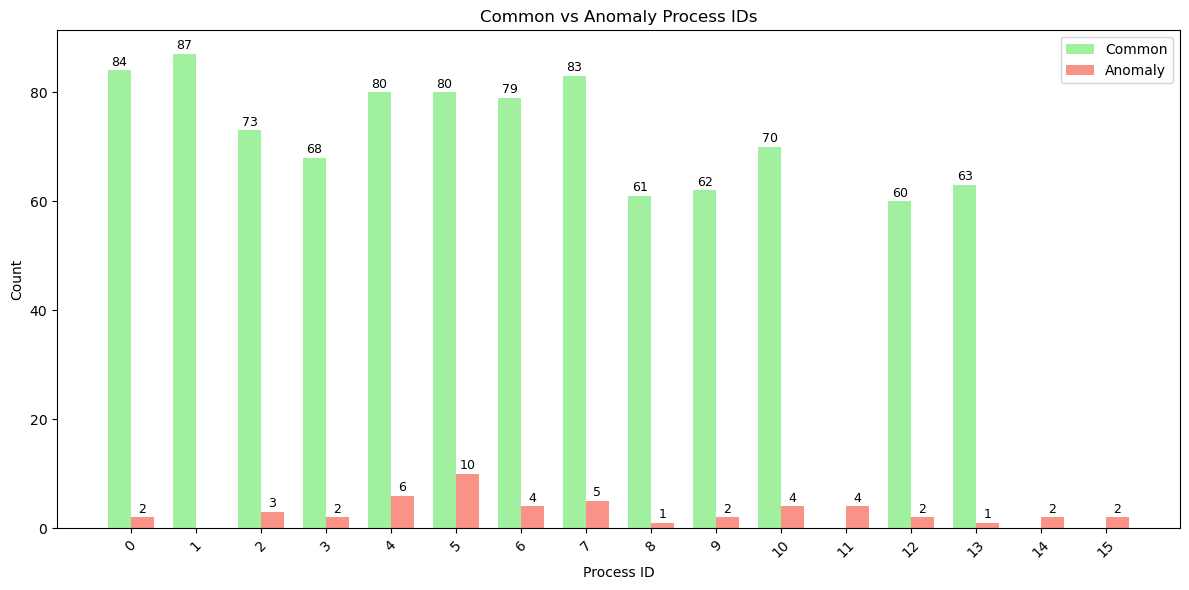

In [15]:
# Split normal and anomalous
anomalies = df[df["is_anomaly"] == 1]
normals   = df[df["is_anomaly"] == 0]

# Count occurrences of each process_id
anomaly_counts = anomalies["process_id"].value_counts().sort_index()
normal_counts  = normals["process_id"].value_counts().sort_index()

# Make sure both have same x-axis
all_ids = sorted(set(normal_counts.index) | set(anomaly_counts.index))
anomaly_counts = anomaly_counts.reindex(all_ids, fill_value=0)
normal_counts  = normal_counts.reindex(all_ids, fill_value=0)

# Bar positions
x = np.arange(len(all_ids))
width = 0.35

# Plot
plt.figure(figsize=(12, 6))
bars_normal = plt.bar(x - width/2, normal_counts.values, width, 
                      label="Common", color="lightgreen", alpha=0.85)
bars_anomaly = plt.bar(x + width/2, anomaly_counts.values, width, 
                       label="Anomaly", color="salmon", alpha=0.85)

# Add counts above bars, skip zeros
for bar in bars_normal:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, str(int(height)), 
                 ha='center', va='bottom', fontsize=9)

for bar in bars_anomaly:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, str(int(height)), 
                 ha='center', va='bottom', fontsize=9)

plt.xlabel("Process ID")
plt.ylabel("Count")
plt.title("Common vs Anomaly Process IDs")
plt.xticks(x, all_ids, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# scatter plot parent_process over process

In [16]:
# Parse timestamp column into datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%d-%m-%y %H:%M:%S")

# Day of week (Monday=0 ... Sunday=6)
# But you want Saturday=0 ... Friday=6
df["day_of_week"] = (df["timestamp"].dt.dayofweek + 2) % 7

# Extract hour (0–23)
df["hour"] = df["timestamp"].dt.hour

# Work hours = 09:00 to 19:59
df["is_work_hours"] = df["hour"].between(9, 19).astype(int)

df.head()

,timestamp,user_name,parent_process,process,command,command_length,num_args,is_anomaly,length_bin,parent_process_id,process_id,day_of_week,hour,is_work_hours
0,2025-11-02 06:13:08,svc_unknown,winword.exe,msiexec.exe,"powershell -Command ""$wc = New-Object System.N...",129,7,1,120–130,0,0,1,6,0
1,2025-11-02 09:50:21,oleg.kov,winword.exe,msiexec.exe,cmd.exe /c echo hello,21,4,0,20–30,0,0,1,9,1
2,2025-11-02 10:18:14,svc_sql,searchui.exe,schtasks.exe,msiexec /i C:\installers\app.msi /qn,36,4,0,30–40,1,1,1,10,1
3,2025-11-02 11:16:03,li.chen,onedrive.exe,net.exe,whoami,6,1,0,0–10,2,2,1,11,1
4,2025-11-02 11:31:33,svc_sql,msedge.exe,msiexec.exe,Get-Service,11,1,0,10–20,3,0,1,11,1


In [ ]:
#

In [17]:
# Create a pair column
df["parent_child_frequency"] = df["parent_process"] + " -> " + df["process"]

# Count frequency of each pair
pair_counts = df["parent_child_frequency"].value_counts()

# Map back to dataframe
df["parent_child_frequency"] = df["parent_child_frequency"].map(pair_counts)

df.head()

,timestamp,user_name,parent_process,process,command,command_length,num_args,is_anomaly,length_bin,parent_process_id,process_id,day_of_week,hour,is_work_hours,parent_child_frequency
0,2025-11-02 06:13:08,svc_unknown,winword.exe,msiexec.exe,"powershell -Command ""$wc = New-Object System.N...",129,7,1,120–130,0,0,1,6,0,5
1,2025-11-02 09:50:21,oleg.kov,winword.exe,msiexec.exe,cmd.exe /c echo hello,21,4,0,20–30,0,0,1,9,1,5
2,2025-11-02 10:18:14,svc_sql,searchui.exe,schtasks.exe,msiexec /i C:\installers\app.msi /qn,36,4,0,30–40,1,1,1,10,1,9
3,2025-11-02 11:16:03,li.chen,onedrive.exe,net.exe,whoami,6,1,0,0–10,2,2,1,11,1,8
4,2025-11-02 11:31:33,svc_sql,msedge.exe,msiexec.exe,Get-Service,11,1,0,10–20,3,0,1,11,1,4


In [18]:
from scipy.stats import zscore

# Compute z-scores
df["command_length_zscore"] = zscore(df["command_length"])
df["num_args_zscore"] = zscore(df["num_args"])

df.head()

,timestamp,user_name,parent_process,process,command,command_length,num_args,is_anomaly,length_bin,parent_process_id,process_id,day_of_week,hour,is_work_hours,parent_child_frequency,command_length_zscore,num_args_zscore
0,2025-11-02 06:13:08,svc_unknown,winword.exe,msiexec.exe,"powershell -Command ""$wc = New-Object System.N...",129,7,1,120–130,0,0,1,6,0,5,3.904293,1.668610
1,2025-11-02 09:50:21,oleg.kov,winword.exe,msiexec.exe,cmd.exe /c echo hello,21,4,0,20–30,0,0,1,9,1,5,-0.413156,0.361263
2,2025-11-02 10:18:14,svc_sql,searchui.exe,schtasks.exe,msiexec /i C:\installers\app.msi /qn,36,4,0,30–40,1,1,1,10,1,9,0.186490,0.361263
3,2025-11-02 11:16:03,li.chen,onedrive.exe,net.exe,whoami,6,1,0,0–10,2,2,1,11,1,8,-1.012802,-0.946083
4,2025-11-02 11:31:33,svc_sql,msedge.exe,msiexec.exe,Get-Service,11,1,0,10–20,3,0,1,11,1,4,-0.812920,-0.946083


In [ ]:
# לקודד יוזרים